In [402]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Wczytanie i preprocessing danych

In [403]:
house_data = pd.read_csv("train_data.csv")

print(house_data.N_elevators.describe())

count    4124.000000
mean       11.055771
std         7.717030
min         0.000000
25%         5.000000
50%        11.000000
75%        16.000000
max        27.000000
Name: N_elevators, dtype: float64


In [404]:
categorical_columns = ["SubwayStation"]
categorical_values = pd.get_dummies(house_data[categorical_columns])
categorical_values.head()

,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,False,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,False
2,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False


In [405]:
house_data.drop(columns=categorical_columns, inplace=True)
house_data.HeatingType = (house_data.HeatingType == "individual_heating").astype(int)
house_data.AptManageType = (house_data.AptManageType == "management_in_trust").astype(int)

categorical_columns = house_data.select_dtypes(include=['object']).columns
house_data = pd.get_dummies(house_data, columns=categorical_columns)

# We have 3 classes - 1. SalePrice < 100000, 2. 1000000 <= SalePrice < 350000, 3. SalePrice >= 350000
house_data['SalePrice'] = pd.cut(house_data['SalePrice'], bins=[0, 100000, 350000, 1000000], labels=[0, 1, 2])
house_data = pd.get_dummies(house_data, columns=['SalePrice'])



# -> int
house_data = house_data.astype(int)

house_data.head()

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,...,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min,TimeToSubway_0-5min,TimeToSubway_10min~15min,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SalePrice_0,SalePrice_1,SalePrice_2
0,2006,814,3,1,1,111,184,3,0,5,...,0,1,0,1,0,0,0,0,1,0
1,1985,587,8,1,0,80,76,2,2,3,...,0,0,0,0,0,1,0,1,0,0
2,1985,587,6,1,0,80,76,2,2,3,...,0,0,0,0,0,1,0,1,0,0
3,2006,2056,8,1,1,249,536,5,11,5,...,0,0,1,0,0,0,0,0,0,1
4,1992,644,2,1,0,142,79,4,8,3,...,0,1,0,0,1,0,0,1,0,0


## Niezbalansowanie danych

In [406]:
print(house_data['SalePrice_0'].sum())
print(house_data['SalePrice_1'].sum())
print(house_data['SalePrice_2'].sum())

562
2992
570


## Przygotowanie zbiorów

In [407]:
train = house_data.sample(frac=0.8, random_state=42) 
test = house_data.drop(train.index)

# Shape
print(train.dtypes)

YearBuilt                          int32
Size(sqf)                          int32
Floor                              int32
HeatingType                        int32
AptManageType                      int32
N_Parkinglot(Ground)               int32
N_Parkinglot(Basement)             int32
N_manager                          int32
N_elevators                        int32
N_FacilitiesInApt                  int32
N_FacilitiesNearBy(Total)          int32
N_SchoolNearBy(Total)              int32
HallwayType_corridor               int32
HallwayType_mixed                  int32
HallwayType_terraced               int32
TimeToBusStop_0~5min               int32
TimeToBusStop_10min~15min          int32
TimeToBusStop_5min~10min           int32
TimeToSubway_0-5min                int32
TimeToSubway_10min~15min           int32
TimeToSubway_15min~20min           int32
TimeToSubway_5min~10min            int32
TimeToSubway_no_bus_stop_nearby    int32
SalePrice_0                        int32
SalePrice_1     

In [408]:
train_y = train[['SalePrice_0', 'SalePrice_1', 'SalePrice_2']]
train_x = train.drop(columns=['SalePrice_0', 'SalePrice_1', 'SalePrice_2'])
test_y = test[['SalePrice_0', 'SalePrice_1', 'SalePrice_2']]
test_x = test.drop(columns=['SalePrice_0', 'SalePrice_1', 'SalePrice_2'])

# Normalize data
train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()

In [409]:
import torch
import numpy as np
import torch.utils.data as data
import torch.nn as nn

train = house_data.sample(frac=0.8, random_state=42)
test = house_data.drop(train.index)

train_indices = house_data.index.isin(train.index)

categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()

train_x_tensor = torch.from_numpy(train_x.values).float()
train_y_tensor = torch.from_numpy(train_y.values).float()

test_x_tensor = torch.from_numpy(test_x.values).float()
test_y_tensor = torch.from_numpy(test_y.values).float()

print(f"train_x_tensor: {train_x_tensor.shape}")
print(f"categorical_data: {categorical_data.shape}")
print(f"train_y_tensor: {train_y_tensor.shape}")

train_dataset = data.TensorDataset(train_x_tensor, categorical_data, train_y_tensor)
test_dataset = data.TensorDataset(test_x_tensor, test_categorical_data, test_y_tensor)

print(next(iter(train_dataset)))

train_x_tensor: torch.Size([3299, 23])
categorical_data: torch.Size([3299, 8])
train_y_tensor: torch.Size([3299, 3])
(tensor([ 0.4690,  1.8834, -1.2019,  0.2197,  0.2486, -0.8696,  0.0884, -0.4063,
        -0.7840, -0.3421, -0.2564, -1.3381, -0.3450, -0.6410,  0.8125,  0.5559,
        -0.0874, -0.5442,  1.0531, -0.3886, -0.4477, -0.4805, -0.2041]), tensor([0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 1.]))


## Sieć neuronowa

In [410]:
class HouseNet(nn.Module):
    def __init__(self, input_dim, cat_dim, dropout_rate=0.4):
        super(HouseNet, self).__init__()
        self.emb_layer = nn.Linear(cat_dim, cat_dim)
        self.act_emb = nn.Tanh()
        
        # Pierwsza warstwa - poprawione użycie wymiarów
        self.lin1 = nn.Linear(input_dim + cat_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = nn.LeakyReLU(0.1)
        self.drop1 = nn.Dropout(dropout_rate)
        
        # Pozostałe warstwy
        self.lin2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act2 = nn.LeakyReLU(0.1)
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.lin3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.act3 = nn.LeakyReLU(0.1)
        self.drop3 = nn.Dropout(dropout_rate)
        
        self.lin4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.act4 = nn.LeakyReLU(0.1)
        
        self.lin5 = nn.Linear(64, 3)

    def forward(self, x, cat_x):
        # Embedding kategorycznych cech
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        
        # Łączenie cech
        x_combined = torch.cat([x, cat_x_embedded], dim=1)
        
        # Warstwy sieci - naprawiony przepływ danych
        x = self.lin1(x_combined)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)
        
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)
        
        x = self.lin3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.drop3(x)
        
        x = self.lin4(x)
        x = self.bn4(x)
        x = self.act4(x)
        
        x = self.lin5(x)
        return x

In [411]:
# Prepare model
device = torch.device("cuda")
model = HouseNet(input_dim=train_x.shape[1], cat_dim=categorical_data.shape[1])
model.to(device)

HouseNet(
  (emb_layer): Linear(in_features=8, out_features=8, bias=True)
  (act_emb): Tanh()
  (lin1): Linear(in_features=31, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.1)
  (drop1): Dropout(p=0.4, inplace=False)
  (lin2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.1)
  (drop2): Dropout(p=0.4, inplace=False)
  (lin3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): LeakyReLU(negative_slope=0.1)
  (drop3): Dropout(p=0.4, inplace=False)
  (lin4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): LeakyReLU(negative_slope=0.1)
  (lin5): Line

In [412]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_module = nn.MSELoss()

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False
)

## Trenowanie modelu

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10, train loss: 0.0996, val loss: 0.0798
Epoch: 20, train loss: 0.0856, val loss: 0.0718
Epoch: 30, train loss: 0.0786, val loss: 0.0666
Epoch: 40, train loss: 0.0742, val loss: 0.0649
Epoch: 50, train loss: 0.0734, val loss: 0.0641
Epoch: 60, train loss: 0.0698, val loss: 0.0634
Epoch: 70, train loss: 0.0695, val loss: 0.0622
Epoch: 80, train loss: 0.0684, val loss: 0.0620
Epoch: 90, train loss: 0.0672, val loss: 0.0616
Epoch: 100, train loss: 0.0656, val loss: 0.0612
Epoch: 110, train loss: 0.0674, val loss: 0.0608
Epoch: 120, train loss: 0.0645, val loss: 0.0607
Epoch: 130, train loss: 0.0649, val loss: 0.0606
Epoch: 140, train loss: 0.0654, val loss: 0.0606
Epoch: 150, train loss: 0.0638, val loss: 0.0604
Epoch: 160, train loss: 0.0637, val loss: 0.0601
Epoch: 170, train loss: 0.0633, val loss: 0.0607
Epoch: 180, train loss: 0.0641, val loss: 0.0604
Epoch: 190, train loss: 0.0632, val loss: 0.0601
Epoch: 200, train loss: 0.0617, val loss: 0.0605
Epoch: 210, train loss: 0.062

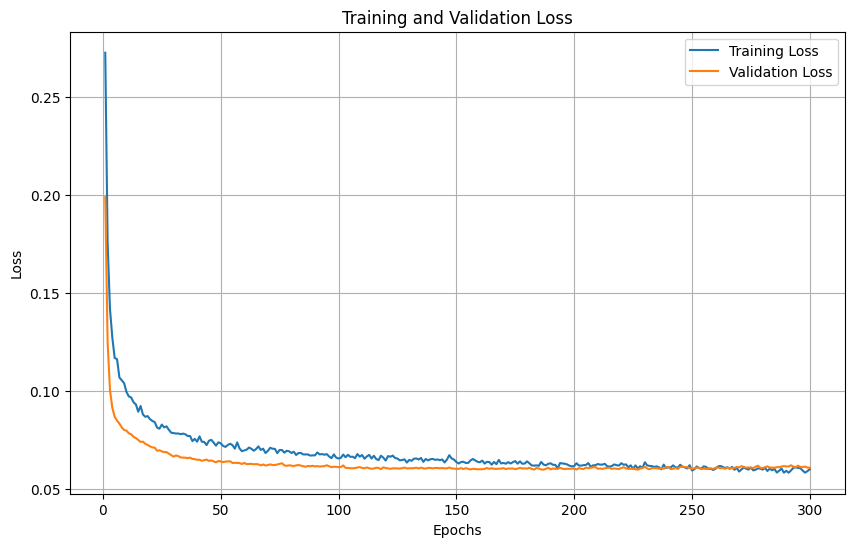

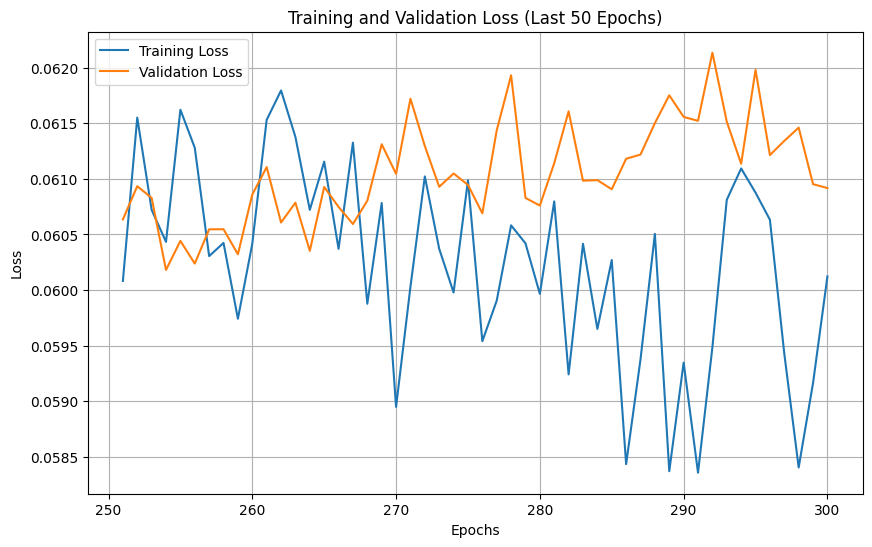

In [413]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


train_losses = []
val_losses = []

for epoch in tqdm(range(300)):
    model.train()
    total_loss = 0
    batches = 0
    
    for x, cat_x, labels in train_data_loader:
        x = x.to(device)
        cat_x = cat_x.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        out = model(x, cat_x)
        
        loss = loss_module(out, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batches += 1
    
    avg_loss = total_loss / batches
    train_losses.append(avg_loss)
    
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for x, cat_x, labels in test_data_loader:
            x = x.to(device)
            cat_x = cat_x.to(device)
            labels = labels.to(device)
            
            out = model(x, cat_x)
            loss = loss_module(out, labels)
            
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        tqdm.write(f"Epoch: {epoch+1}, train loss: {avg_loss:.4f}, val loss: {avg_val_loss:.4f}")
    

# Wizualizacja strat
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Dodatkowa wizualizacja - zbliżenie na końcowe epoki
plt.figure(figsize=(10, 6))
cut_point = min(50, len(train_losses))
plt.plot(range(len(train_losses) - cut_point + 1, len(train_losses) + 1), train_losses[-cut_point:], label='Training Loss')
plt.plot(range(len(val_losses) - cut_point + 1, len(val_losses) + 1), val_losses[-cut_point:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Last 50 Epochs)')
plt.legend()
plt.grid(True)
plt.show()

## Testowanie modelu

In [414]:
model.eval()

for data_inputs, cat_y, data_labels in test_data_loader:
    data_inputs = data_inputs.to(device)
    cat_y = cat_y.to(device)
    data_labels = data_labels.to(device)

    preds = model(data_inputs.float(), cat_y)
    preds = preds.squeeze(dim=1)

    # round to int
    preds = torch.round(preds)

    predicted = 0
    for i in range(len(data_labels)):
        if data_labels[i][0] == preds[i][0] and data_labels[i][1] == preds[i][1] and data_labels[i][2] == preds[i][2]:
            predicted += 1
    
    print(f"Accuracy: {predicted/len(data_labels)}")

Accuracy: 0.8703030303030304
